<a href="/assets/tutorial12_example.ipynb" class="link-button">Download</a>
<a href="https://colab.research.google.com/github/technion046195/technion046195/blob/master/content/tutorial12/example.ipynb" target="_blank">
<img src="../assets/colab-badge.svg" style="display:inline"/>
</a>

<center><h1>
תרגול 12 - דוגמא מעשית
</h1></center>

## Setup

In [ ]:
## Importing packages
import os # A build in package for interacting with the OS. For example to create a folder.
import numpy as np  # Numerical package (mainly multi-dimensional arrays and linear algebra)
import pandas as pd  # A package for working with data frames
import matplotlib.pyplot as plt  # A plotting package
import imageio  # A package to read and write image (is used here to save gif images)
import tabulate  # A package from pretty printing tables
from graphviz import Digraph  # A package for plothing graphs (of nodes and edges)
import tqdm.notebook as tqdm

## Setup matplotlib to output figures into the notebook
## - To make the figures interactive (zoomable, tooltip, etc.) use ""%matplotlib notebook" instead
%matplotlib inline

## Setting some nice matplotlib defaults
plt.rcParams['figure.figsize'] = (4.5, 4.5)  # Set default plot's sizes
plt.rcParams['figure.dpi'] = 120  # Set default plot's dpi (increase fonts' size)
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Auxiliary function for prining equations, pandas tables and images in cells output
from IPython.core.display import display, HTML, Latex, Markdown

## Create output folder
if not os.path.isdir('./output'):
    os.mkdir('./output')

### Data Inspection

In [ ]:
data_file = 'https://technion046195.netlify.app/datasets/nyc_taxi_rides.csv'

## Loading the data
dataset = pd.read_csv(data_file)

## Show the first 10 rows
dataset

,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,pickup_easting,pickup_northing,dropoff_easting,dropoff_northing,duration,day_of_week,day_of_month,time_of_day
0,2,2.768065,2,9.5,0.00,586.996941,4512.979705,588.155118,4515.180889,11.516667,3,13,12.801944
1,1,3.218680,2,10.0,0.00,587.151523,4512.923924,584.850489,4512.632082,12.666667,6,16,20.961389
2,1,2.574944,1,7.0,2.49,587.005357,4513.359700,585.434188,4513.174964,5.516667,0,31,20.412778
3,1,0.965604,1,7.5,1.65,586.648975,4511.729212,586.671530,4512.554065,9.883333,1,25,13.031389
4,1,2.462290,1,7.5,1.66,586.967178,4511.894301,585.262474,4511.755477,8.683333,2,5,7.703333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,3.218680,2,8.0,0.00,586.185469,4513.033744,585.468560,4510.530082,6.400000,4,28,6.925000
99996,5,1.142631,1,4.0,1.32,585.765009,4512.580782,585.200602,4511.590442,1.666667,1,25,5.041667
99997,1,5.471756,2,12.5,0.00,587.498875,4512.905997,591.728405,4512.904235,11.666667,6,9,15.407500
99998,1,3.894603,1,11.5,2.00,589.082301,4511.109238,591.331933,4513.822199,14.383333,5,1,21.158889


### Plotting Drop Off  Points

In [ ]:
import skimage.io  # Another package to heandle images

## Load and image of the streets of NY
ny_map_image = skimage.io.imread('https://technion046195.netlify.app/assets/nyc_map.png')

## The geografic bounding box of the map data as [West-longtitude East-longtitude South-latitude North-latitude]:
bbox = [582.5, 592.5, 4505.5, 4515.5]  

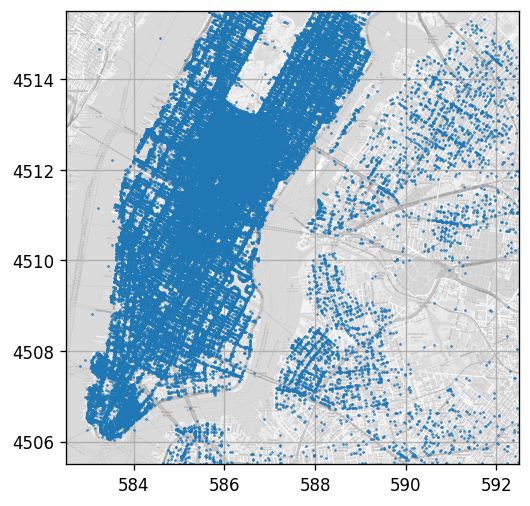

In [ ]:
## Create the figure and axis
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.grid(True)

## Plot the map
ax.imshow(ny_map_image, extent=bbox, cmap='gray', alpha=0.7)
ax.plot(dataset['dropoff_easting'], dataset['dropoff_northing'], '.', markersize=1)
fig.savefig('./output/pickups.png')

## Train-Validation-Test split

In [ ]:
n_samples = len(dataset)

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(1)

## Generating a vector of indices
indices = np.arange(n_samples)

## Shuffle the indices
rand_gen.shuffle(indices)

## Split the indices into 60% train / 20% validation / 20% test
n_samples_train = int(n_samples * 0.6)
n_samples_val = int(n_samples * 0.2)
train_indices = indices[:n_samples_train]
val_indices = indices[n_samples_train:(n_samples_train + n_samples_val)]
test_indices = indices[(n_samples_train + n_samples_val):]

train_set = dataset.iloc[train_indices]
val_set = dataset.iloc[val_indices]
test_set = dataset.iloc[test_indices]

### K-Means

Number of steps: 76


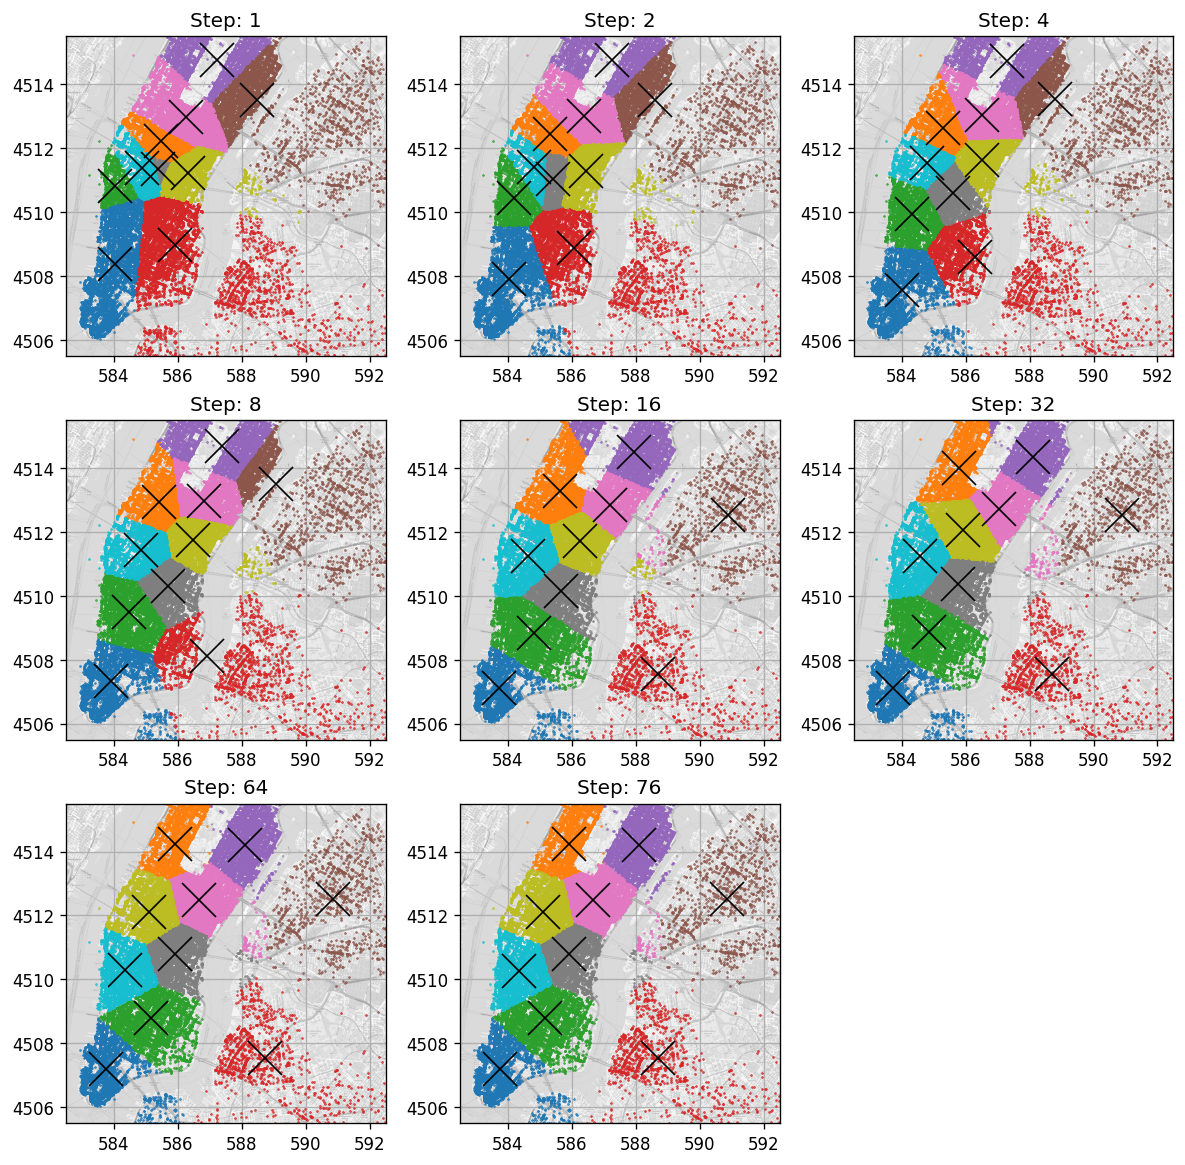

In [ ]:
from scipy.spatial import distance  # A function for efficiently calculating all the distances between points in two lists of points.

## Set K
k = 10

## Define x (the matrix of the drop off locations)
x = train_set[['dropoff_easting', 'dropoff_northing']].values
n_samples = len(x)

## Create a random generator using a fixed seed (we fix the seed for reproducible results)
rand_gen = np.random.RandomState(0)

## Initialize the means using k random points from the dataset
means = x[rand_gen.randint(low=0, high=n_samples, size=k)]
assignment = np.zeros(n_samples, dtype=int)

## Prepare figure and plotting counters
next_axis = 0
fig, axis_list = plt.subplots(3, 3, figsize=(12, 12))
i_step = 0
next_plot_step = 1

stop_iterations = False
while not stop_iterations:
    i_step += 1
    assignment_old = assignment

    ## Step 1: Assign points to means
    distances = distance.cdist(x, means, 'euclidean')
    assignment = np.argmin(distances, axis=1)
    
    ## Stop criteria
    if (assignment == assignment_old).all():
        stop_iterations = True

    ## Step 2: Update means
    for i_cluster in range(k):
        cluster_indices = assignment == i_cluster
        means[i_cluster] = x[cluster_indices].mean(axis=0)

    ## Plot clusters and means
    if (i_step == next_plot_step) or (stop_iterations):
        ax = axis_list.flat[next_axis]
        ax.grid(True)
        ax.set_title('Step: {}'.format(i_step))

        ax.imshow(ny_map_image, extent=bbox, cmap='gray', alpha=0.7)
        for i_cluster in range(k):
            cluster_indices = assignment == i_cluster
            ax.plot(x[cluster_indices, 0], x[cluster_indices, 1], '.', markersize=1)
        ax.plot(means[:, 0], means[:, 1], 'xk', markersize=20)[0]
        next_plot_step *= 2
        next_axis += 1

for i in range(next_axis, len(axis_list.flat)):
    axis_list.flat[i].set_visible(False)
        
print('Number of steps: {}'.format(i_step))
parking_lots_locations = means
fig.savefig('./output/taxis_k_means.png')

#### Evaluation on train set

$$
\hat{R}\left(\left\{\boldsymbol{c}_i\right\}\right)=\frac{1}{N}\sum_{\boldsymbol{x}_j}\min_{\boldsymbol{c}\in\left\{\boldsymbol{c}\right\}}\left\lVert\boldsymbol{x}_j-\boldsymbol{c}\right\rVert
$$

In [ ]:
## Calculate distances to all parking lots
distances = distance.cdist(x, parking_lots_locations, 'euclidean')

## Calculate the average of the distances to the colsest parking lot to each point
train_risk = distances.min(axis=1).mean()

print('The average ride distance to the closest parking lots is approximately {:.02f} km'.format(train_risk))

The average ride distance to the closest parking lots is approximately 0.71 km


#### Evaluation on test set

In [ ]:
## Define x for the test set
x_val = val_set[['dropoff_easting', 'dropoff_northing']].values

## Calculate distances to all parking lots
distances = distance.cdist(x_val, parking_lots_locations, 'euclidean')

## Calculate the average of the distances to the colsest parking lot to each point
val_risk = distances.min(axis=1).mean()

print('The average ride distance to the closest parking lots is approximatley {:.02f} km'.format(val_risk))

The average ride distance to the closest parking lots is approximatley 0.71 km


## Finding The Optimal Number of Parking Lots

The empirical risk function:


$$
\hat{R}\left(\left\{\boldsymbol{c}_i\right\}, K\right)= 10\cdot K+300\cdot\frac{1}{N}\sum_{i=1}^K\sum_{\boldsymbol{x}_j\in S_i}\left\lVert\boldsymbol{x}_j-\boldsymbol{c}_i\right\rVert
$$


The optimal number of parking lots is: 12
The optimal average ride distance is: 0.63 Km
The train risk is 307.73 k$


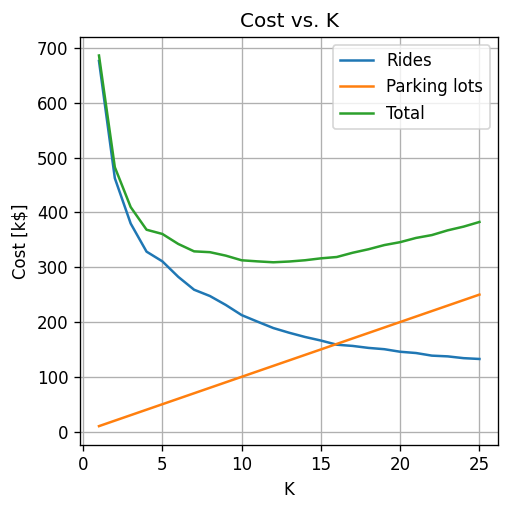

In [ ]:
## import KMeans from scikit-learn
from sklearn.cluster import KMeans

cost_per_parking = 10
cost_per_avarage_distance = 300

## Define the grid of K's over we will search for our solution
k_grid = np.arange(1, 26, 1)

## Updates the datasets
x = train_set[['dropoff_easting', 'dropoff_northing']].values
x_val = val_set[['dropoff_easting', 'dropoff_northing']].values
x_test = test_set[['dropoff_easting', 'dropoff_northing']].values

## Initialize the list of the average ride distance
average_distance_array = np.zeros(len(k_grid), dtype=float)

## Create a random generator using a fixed seed 
rand_gen = np.random.RandomState(0)

best_risk_so_far = np.inf
optimal_k = None
optimal_average_distance = None
optimal_centers = None
for i_k, k in enumerate(tqdm.tqdm(k_grid)):
    
    ## Calculate ceneters and clusters
    kmeans = KMeans(n_clusters=k, random_state=rand_gen)
    kmeans.fit(x)
    centers = kmeans.cluster_centers_
    
    ## Evaluate the empirical risk
    assignments = kmeans.predict(x_val)
    distances = np.linalg.norm(x_val - centers[assignments], axis=1)
    average_distance = distances.mean()
    risk = cost_per_parking * k + cost_per_avarage_distance * average_distance
    
    ## If this is the best risk so far save the optimal results
    if risk < best_risk_so_far:
        best_risk_so_far = risk
        optimal_k = k
        optimal_average_distance = average_distance
        optimal_centers = centers
     
    ## Save average distance for the later plot
    average_distance_array[i_k] = average_distance

## Plot
fig, ax = plt.subplots()
ax.plot(k_grid, average_distance_array * cost_per_avarage_distance, label='Rides')
ax.plot(k_grid, k_grid * cost_per_parking, label='Parking lots')
ax.plot(k_grid, k_grid * cost_per_parking + average_distance_array * cost_per_avarage_distance, label='Total')
ax.set_title('Cost vs. K')
ax.set_ylabel('Cost [k$]')
ax.set_xlabel('K')
ax.legend()
fig.savefig('./output/taxis_scan_for_k.png')

## Calculate the test results
distances = distance.cdist(x_test, optimal_centers, 'euclidean')
test_average_distance = distances.min(axis=1).mean()
test_risk = cost_per_parking * optimal_k + cost_per_avarage_distance * test_average_distance

print('The optimal number of parking lots is: {}'.format(optimal_k))
print('The optimal average ride distance is: {:.2f} Km'.format(test_average_distance))
print('The train risk is {:.2f} k$'.format(test_risk))

#### Evaluation on test set

In [ ]:
## Calculate distances to all parking lots
distances = distance.cdist(x_test, optimal_centers, 'euclidean')

## Calculate the average distance and risk
test_average_distance = distances.min(axis=1).mean()
test_risk = cost_per_parking * optimal_k + cost_per_avarage_distance * test_average_distance

print('The optimal average ride distance is: {:.2f} Km'.format(test_average_distance))
print('The train risk is {:.2f} k$'.format(test_risk))

The optimal average ride distance is: 0.63 Km
The train risk is 307.73 k$
